<a href="https://colab.research.google.com/github/SHAMIK-97/NLP-POS_tagging/blob/main/POS_tagging_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# The libraries we will use are imported here, in case of runtime problems
import os, shutil  #  file management
import sys
import pandas as pd  #  dataframe management
import numpy as np  #  data manipulation
# imports for plotting and evaluation
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay


In [ ]:
dataset_name = "dependency_treebank"

In [ ]:
folder = os.getcwd()

print("Current work directory: " + str(folder))

dataset_folder = os.path.join(os.getcwd(), "Datasets")

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

for filename in os.listdir(dataset_folder):
    file_path = os.path.join(dataset_folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

print("Cleaned")

Current work directory: /content
Cleaned


##Folder path creatrion and extration of dataset

In [ ]:
from urllib import request
from zipfile import ZipFile

print(f"Current work directory: {os.getcwd()}")
dataset_folder = os.path.join(os.getcwd(), "Datasets")

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"
dataset_path = os.path.join(dataset_folder, "dependency_treebank.zip")
print(dataset_path)

def download_dataset(download_path: str, url: str):
    if not os.path.exists(download_path):
        print("Downloading dataset...")
        request.urlretrieve(url, download_path)
        print("Download complete!")

def extract_dataset(download_path: str):
    print("Extracting dataset... (it may take a while...)")
    zipAll = ZipFile(download_path)
    zipAll.extractall(dataset_folder)
    print("Extraction completed!")
    return zipAll


download_dataset(dataset_path, url)
zipAll = extract_dataset(dataset_path)

Current work directory: /content
/content/Datasets/dependency_treebank.zip
Download complete!
Extracting dataset... (it may take a while...)
Extraction completed!


##Preparing the Train validation test split from the downloaded corpus

# spliting documents 1-100 are the train set, 101-150 validation set, 151-199 test set.

Splitting is done in sentences



In [ ]:
from tables import Column
import re

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|!:-@,;\.?\']')
files = zipAll.namelist()
files.sort()
df_columns = ['word','tag','value']
df_final = []
print('No. of files: {}'.format(len(files)))

# We split the sentences when we find a . (period)
# it works for sentences and tags
def split_sentences(sentences,tags):
    final_sentences,final_tags=[],[]
    ret_sentences,ret_tags=[],[]
    for i in range(0,len(sentences)):
        ret_sentences.append(sentences[i])
        ret_tags.append(tags[i])
        if sentences[i] == '.':
            final_sentences.append(ret_sentences)
            final_tags.append(ret_tags)
            ret_sentences,ret_tags=[],[]
    if len(ret_sentences) >0:
        final_sentences.append(ret_sentences)
        final_tags.append(ret_tags)

    return(final_sentences,final_tags)

#This for the testing of the sentence and tag splitting function
x,y = split_sentences(['The','best','run','of','all','.','It','is','running','for','you'],
                      ['DT','JJS','VB','IN','DT','.','PRP','VB','VBG','IN','PRP'])
print('x:',x)
print('y:', y)

# spliting documents 1-100 are the train set, 101-150 validation set, 151-199 test set.
train_sentences, train_tags =[], []
test_sentences, test_tags =[], []
validation_sentences, validation_tags =[], []

files = zipAll.namelist()
files.sort()
print('No. of files: {}'.format(len(files)))
for f in range(1,len(files)):
  my_df = pd.read_csv(zipAll.open(files[f]), header=None,
                    delimiter='\t', names=['word','tag','value'])
  if f in range(0,101):
    x,y = split_sentences(my_df['word'].to_numpy(),my_df['tag'].to_numpy())
    for i in range(0,len(x)):
      train_sentences.append(x[i])
      train_tags.append(y[i])
  if f in range(101,151):
    x,y = split_sentences(my_df['word'].to_numpy(),my_df['tag'].to_numpy())
    for i in range(0,len(x)):
      validation_sentences.append(x[i])
      validation_tags.append(y[i])
  if f > 150:
    x,y = split_sentences(my_df['word'].to_numpy(),my_df['tag'].to_numpy())
    for i in range(0,len(x)):
      test_sentences.append(x[i])
      test_tags.append(y[i])


# Let's discover the number of sentences to split into training, validation and test sets:
# Finally after we run on all sentences, we determine the number of test sentences
number_training_sentences = len(train_sentences)
number_validation_sentences = len(validation_sentences)
number_test_sentences = len(test_sentences)
number_sentences = number_training_sentences + number_validation_sentences + number_test_sentences
number_tags = len(train_tags) + len(validation_tags) + len(test_tags)

print('No. sentences: {}'.format(number_sentences))
print('No. tag sentences: {}'.format(number_tags))
print('No. Training sentences: {}'.format(number_training_sentences))
print('No. Validation sentences: {}'.format(number_validation_sentences))
print('No. Test sentences: {}'.format(number_test_sentences))
print("Successful Split")


No. of files: 200
x: [['The', 'best', 'run', 'of', 'all', '.'], ['It', 'is', 'running', 'for', 'you']]
y: [['DT', 'JJS', 'VB', 'IN', 'DT', '.'], ['PRP', 'VB', 'VBG', 'IN', 'PRP']]
No. of files: 200
No. sentences: 3830
No. tag sentences: 3830
No. Training sentences: 1938
No. Validation sentences: 1256
No. Test sentences: 636
Successful Split


## Data Inspection

*   In order to get insights of the data extracted, we applied some basic methods to get more information about the data.

In [ ]:
# let’s look at first data point of the training dataset
# this is one data point that will be fed to the RNN
print('Sentence Sample:', train_sentences[0])
print('Tag Sample:', train_tags[0])

# In this many-to-many problem, the length of each input and output sequence must be the same.
# Since each word is tagged, it’s important to make sure that the length of input sequence equals the output sequence
print('Length of first input sequence : {}'.format(len(train_sentences[0])))
print('Length of first output sequence : {}'.format(len(train_tags[0])))

Sentence Sample: ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
Tag Sample: ['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.']
Length of first input sequence : 18
Length of first output sequence : 18


## Checking the Data distribution in train validation and test

In [ ]:
train_sentences_frame = pd.Series(train_sentences, name = 'train_sentence')
train_tags_frame = pd.Series(train_tags, name = 'Tags')
test_sentences_frame = pd.Series(test_sentences, name = 'test_sentences')
test_tags_frame = pd.Series(test_tags, name = 'Tags')
validation_sentences_frame = pd.Series(validation_sentences, name = 'validation_sentences')
validation_tags_frame = pd.Series(validation_tags, name = 'Tags')

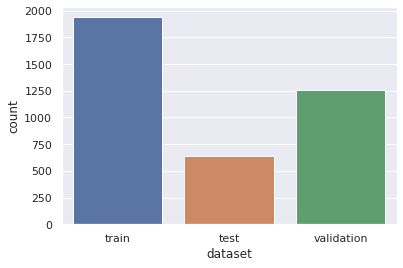

In [ ]:
data = {'train': pd.merge(train_sentences_frame, train_tags_frame,right_index=True, left_index=True),
        'test':  pd.merge(test_sentences_frame,test_tags_frame,right_index=True, left_index=True),
        'validation': pd.merge(validation_sentences_frame, validation_tags_frame,right_index=True, left_index=True)}

sns.set(color_codes=True)

concatenated = pd.concat([data[split].assign(dataset=split) for split in data.keys()])

sns.countplot(x='dataset', data=concatenated)
plt.show()

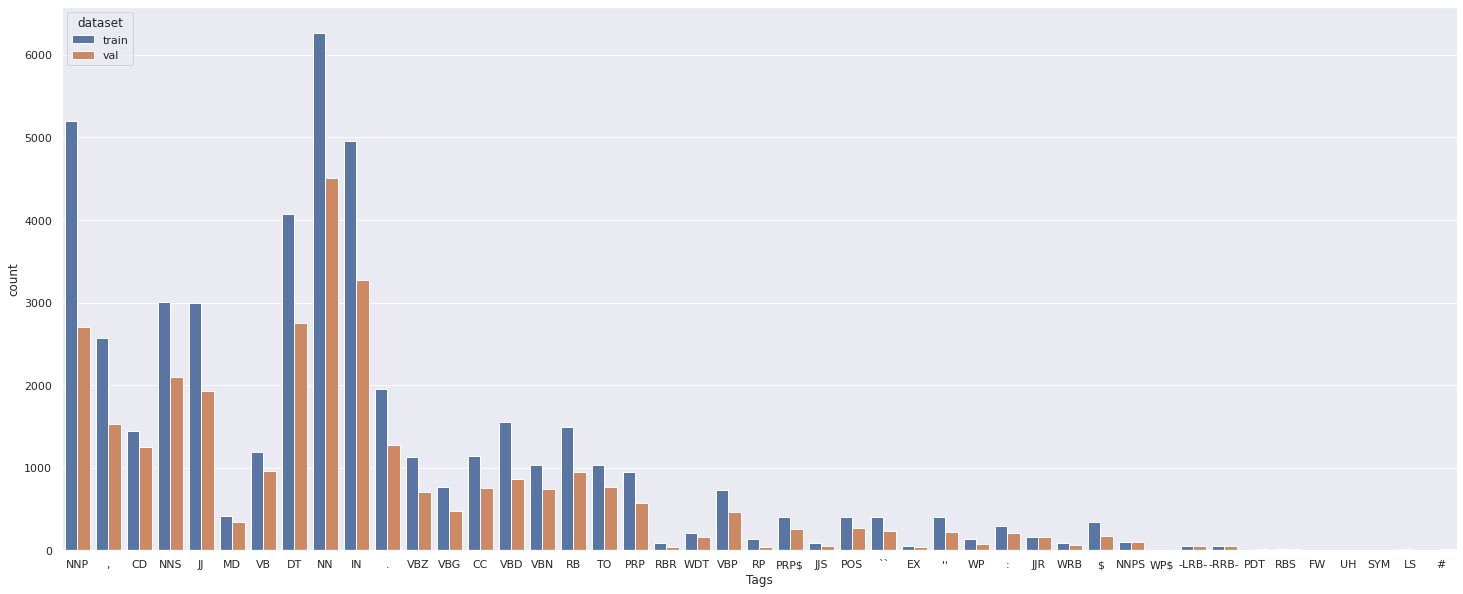

In [ ]:
# Plotting classes distribution in train and val
data_train = data['train'].explode('Tags')
data_val = data['validation'].explode('Tags')

concatenated = pd.concat([data_train.assign(dataset='train'), data_val.assign(dataset='val')])

_, ax = plt.subplots(figsize=(25, 10))
sns.countplot(data=concatenated , x='Tags', hue='dataset', ax=ax)

plt.show()

We can clearly see that the classes are unevenly distributed in each set.



## Tokenization of Data

The next thing we need to figure out is how are we going to feed these inputs to an RNN. If we have to give the words as input to any neural networks then we essentially have to convert them into numbers. We need to create a word embedding or one-hot vectors i.e. a vector of numbers for each word. Therefor, we'll first encode the input and output which will give a blind unique id to each word in the entire corpus for training data and then incrementaly build upon it so that our model can be well utilized in the real world scenarios. On the other hand, we have the Y matrix(tags/output data). We have forty-five POS tags here, treating each of them as a class and each pos tag is converted into one-hot encoding.

In [ ]:
## Question, maybe we should use just the train+validation sentences, and not the whole sentences?
##
from tqdm import tqdm
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
# encode Sentences
def words_tokenizer(sentences,tags):
  word_tokenizer = Tokenizer(oov_token='--oov--')              # instantiate tokeniser
  word_tokenizer.fit_on_texts(sentences)            # fit tokeniser on data
# use the tokeniser to encode input sequence
#X_encoded = word_tokenizer.texts_to_sequences(sentences)
# encode Y
  tag_tokenizer = Tokenizer(oov_token='--oov--')
  tag_tokenizer.fit_on_texts(tags)

    # create a word to index dictionary mapping
  word_count = dict(word_tokenizer.word_counts)
  word_listing = sorted([*word_count.keys()])
  word_to_idx = word_tokenizer.word_index
  word_to_idx[[*word_to_idx.keys()][-1]]  = 0
  word_to_idx = dict(sorted(word_to_idx.items(), key=lambda x: x[1]))
  idx_to_word = dict([(value, key) for key, value in word_to_idx.items()])

  return word_tokenizer, tag_tokenizer, word_listing, word_to_idx, idx_to_word

def evaluate_vocabulary(idx_to_word, word_to_idx, word_listing, check_default_size=False):

    # Check size
    print("[Vocabulary Evaluation] Size checking...")

    assert len(idx_to_word) == len(word_to_idx)
    assert len(idx_to_word) == len(word_listing) + 1

    # Check content
    print("[Vocabulary Evaluation] Content checking...")

    for i in tqdm(range(0, len(idx_to_word))):
        assert idx_to_word[i] in word_to_idx
        assert word_to_idx[idx_to_word[i]] == i


word_tokenizer, tag_tokenizer, word_listing, word_to_idx, idx_to_word = words_tokenizer(list(train_sentences)+list(validation_sentences), list(train_tags))
print("Vocabulary evaluation...")
evaluate_vocabulary(idx_to_word, word_to_idx, word_listing)
print("Evaluation completed!")

Vocabulary evaluation...
[Vocabulary Evaluation] Size checking...
[Vocabulary Evaluation] Content checking...


100%|██████████| 9902/9902 [00:00<00:00, 1077102.58it/s]

Evaluation completed!


## Vocabulary Creation

At this point we can build the word vocabulary of our dataset. This information is the first step of any word embedding method: we need to know the set of atomic entities that build up our corpus.

Definition: a vocabulary is a collection of words occurring in a given dataset. More precisely, each word is recognized and assigned an index.

In order to develop embedding of the words we utilized tokenizer function of keras to give us three different elements that we will use in the code later.

* index2Word - word vocabulary: vocabulary index to word
* word2Index - inverse word vocabulary: word to vocabulary index
* word_listing - word listing: set of unique terms that build up the vocabulary

We will also use the evaluation method of 2nd assignment to verify the correct implementation of the vocabulary. We first create vocabulary for training data to embed it and then we will use the function to describe vocabulary of validation and test data.

In [ ]:
#word_tokenizer, tag_tokenizer, word_listing, word_to_idx, idx_to_word = words_tokenizer(list(train_sentences), list(train_tags))


print('number of unique words:', len(word_listing))
print ('word_listing:', word_listing[0:10])
print ('word_to_idx:', list(word_to_idx)[0:10])
print ('idx_to_word:', list(idx_to_word)[0:10])


number of unique words: 9901
word_listing: ['!', '#', '$', '%', '&', "'", "''", "'30s", "'40s", "'50s"]
word_to_idx: ['liabilities', '--oov--', ',', 'the', '.', 'of', 'to', 'a', 'in', 'and']
idx_to_word: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


## Building the Co-occurence Matrix

As known, embedding methods are based on the principle that similar words will be used in similar contexts. Thus, context information is crucial to determine the meaning of a word.

One basic approach, which falls under the category of sparse representations, is the **co-occurrence matrix**: for each word in the vocabulary we count the number of times each other word appears within the same context window. A simple example is given by image below.

![](https://drive.google.com/uc?export=view&id=1UknGoYvIBBA7ytkSlqm1NhF_lHt0iOwT)

In particular, the context window defines our notion of word context. Consider the following example:

<h3><center> The cat is on the table </center></h3>

We have to consider each word in the sentence and for each we have count words within the context window. Suppose a window of size 2, then we have for the word 'cat':

Current word: cat

Context words: [the, is, on]

Notice how we consider $W$ words back and ahead of current word, where $W$ is the window size.




Let's define the simplest version of a **co-occurrence matrix** based on word counting.



In [ ]:
import scipy.sparse    # defines several types of efficient sparse matrices
import zipfile
import gc
import requests
import time

# Function definition

def co_occurrence_count(sentences, idx_to_word, word_to_idx, window_size=4):
    """
    Builds word-word co-occurrence matrix based on word counts.

    :param df: pre-processed dataset (pandas.DataFrame)
    :param idx_to_word: vocabulary map (index -> word) (dict)
    :param word_to_idx: vocabulary map (word -> index) (dict)

    :return
      - co_occurrence symmetric matrix of size |V| x |V| (|V| = vocabulary size)
    """
    # Using Scipy's DOK matrix since it's efficient in construction.
    out = scipy.sparse.dok_matrix((len(word_to_idx),len(word_to_idx)), dtype=np.uint8)

    # Another closure nested in a function.
    def add_occurrences(sentences):
      for i in range(0, len(sentences)):
        sentence = sentences[i]
        for index in range(len(sentence) - window_size + 1):
          for word1 in sentence[index: index + window_size + 1]:
            for word2 in sentence[index: index + window_size + 1]:
              if word1 != word2:
                #if word1 in vocabulary and word2 in vocabulary:
                out[word_to_idx[word1.lower()], word_to_idx[word2.lower()]] += 1

    add_occurrences(sentences)
    return out.tocsr() # Converting the DOK matrix to a CSR matrix, since it's more efficient for other operations.

# Testing
window_size = 4

# Clean RAM before re-running this code snippet to avoid session crash
if 'co_occurrence_matrix' in globals():
    del co_occurrence_matrix
    gc.collect()
    time.sleep(10.)

print("Building co-occurrence count matrix... (it may take a while...)")
train_sentences = np.array(train_sentences)
train_co_occurrence_matrix = co_occurrence_count(list(train_sentences)+list(validation_sentences), idx_to_word, word_to_idx, window_size=1)
print("Building completed!")

# Evaluation


def evaluate_co_occurrence_matrix(matrix):
    is_sparse = False

    if hasattr(scipy.sparse, type(matrix).__name__):
        print("Detected sparse co-occurrence matrix!")
        is_sparse = True

    # Check symmetry
    print("[Co-occurrence count matrix Evaluation] Symmetry checking...")
    if is_sparse:
        assert (matrix != matrix.transpose()).nnz == 0
    else:
        assert np.equal(matrix, matrix.transpose()).all()


print("Evaluating co-occurrence matrix")
evaluate_co_occurrence_matrix(train_co_occurrence_matrix)
print("Evaluation completed!")

Building co-occurrence count matrix... (it may take a while...)


<ipython-input-12-f87269d94443>:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_sentences = np.array(train_sentences)


Building completed!
Evaluating co-occurrence matrix
Detected sparse co-occurrence matrix!
[Co-occurrence count matrix Evaluation] Symmetry checking...
Evaluation completed!


## Visualizing the Co-occurance matrix

In order to get better insights of the co-occurance matrix, we convert it to dataframe and use pandas methods to visualize it.

In [ ]:
#Representing Co-occurance matrix as dataframe for better visualization and operations
train_co_occurrence_matrix = co_occurrence_count(train_sentences, idx_to_word, word_to_idx, window_size)
df_train_co_occurance= pd.DataFrame.sparse.from_spmatrix(train_co_occurrence_matrix)
df_train_co_occurance.columns = [*word_to_idx]
df_train_co_occurance.index = [*word_to_idx]
df_train_co_occurance.head()

,liabilities,--oov--,",",the,.,of,to,a,in,and,...,accord,pilots,machinists,cleared,472,0.82,delisted,23.25,28.25,duluth
liabilities,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
--oov--,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
",",0,0,0,133,255,142,5,12,19,195,...,0,0,0,0,0,0,0,0,0,0
the,0,0,133,64,5,18,225,29,81,63,...,0,0,0,0,0,0,0,0,0,0
.,0,0,255,5,0,52,15,27,72,211,...,0,0,0,0,0,0,0,0,0,0


## Dense Embeddings of Words

We choose a dense embedding technique, such that all words are encoded to high dimensional space, much smaller than |V| (generally up to $\sim$ 1000). A dense representation is also convenient from a machine learning point of view: we have fewer parameters to learn, and, thus, models are less prone to overfitting. Moreover, words do not belong to separate dimensions anymore, and semantic relationships are easily modeled.

The first step consists of choosing and downloading a pre-trained embedding model. For this assignment, we limit to classic model, GloVe.

Furthermore, some pre-trained embedding model versions may be quite resourcing demanding, depending on the embedding dimension and vocabulary size. We recommend sticking to low dimensional spaces (50, 100, 300) to avoid longer generating times.

Downloading a pre-trained embedding model is quite simple due to existing ad hoc wrappers. In particular, we will use [Gensim](https://radimrehurek.com/gensim/) library for both embedding models as follows.

In [ ]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#So, basically we are trying to embed the sentences above, what we can do is use glove embedding to achieve it

import gensim
import gensim.downloader as gloader

def load_embedding_model(model_type, embedding_dimension=50):
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """

    download_path = ""

    # Find the correct embedding model name
    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"

    elif model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)

    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove")

    # Check download
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model


# Modify these variables as you wish!
# Glove -> 50, 100, 200, 300
# Word2Vec -> 300
embedding_model_type = "Glove"
embedding_dimension = 300

embedding_model = load_embedding_model(embedding_model_type, embedding_dimension)

[==================================================] 100.0% 376.1/376.1MB downloaded


### Out of vocabulary (OOV) words

Before evaluating pre-trained dense word embeddings, it is good practice to check if the model is consistent with our dataset. To do so, we check the number of out-of-vocabulary (OOV) terms.

If the OOV amount is negligible, we can just keep going. On the other hand, we might want to handle OOV terms by assigning them a specific word vector.

**Which one?** One common practice is to assign a random vector, since the embedding model will be part of a deep learning model and, thus, word vectors might be trained during the learning process. Even if that is the case, we can assign an embedding that is more meaningful rather than a random one: for example, we can identify the word embedding of an OOV term as the mean of its neighbour word embeddings.


In [ ]:
# Function definition

def check_OOV_terms(embedding_model, word_listing):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """
    return list(set(word_listing) - set(embedding_model.vocab.keys()))

word_tokenizer, tag_tokenizer, train_word_listing,train_word_to_idx, train_idx_to_word = words_tokenizer(list(train_sentences)+list(validation_sentences), list(train_tags))
#word_tokenizer, tag_tokenizer, word_listing, word_to_idx, idx_to_word = words_tokenizer(list(train_sentences), list(train_tags))


train_oov_terms = check_OOV_terms(embedding_model, train_word_listing)

#print("Total OOV terms: {0} ({1:.2f}%)".format(len(train_oov_terms), float(len(train_oov_terms)) / len(train_word_listing)))

for i in range(len(train_oov_terms) // 10):
  print(train_oov_terms[i * 10:(i+1) * 10])

['colonsville', 'purepac', '236.74', '352.7', 'sacramento-based', '278.7', 'deposits-a', 'muscolina', 'equity-purchase', '70-a-share']
['one-upsmanship', '271,124', '352.9', 'superdot', 'midwesco', 'truth-in-lending', 'cop-killer', '1\\/10th', 'nylev', 'fetal-tissue']
['1\\/8', 'telephone-information', 'non-callable', 'non-biodegradable', 'lap-shoulder', '5\\/8', '3,250,000', 'triple-a-rated', 'middle-ground', 'ctbs']
['purhasing', 'computer-driven', 'executive-office', 'index-arbitrage', 'one-country', 'ednie', '12\\/32', 'tiphook', 'shirt-sleeved', 'autions']
['incentive-bonus', 'heebie-jeebies', '8.467', '22\\/32', '13.625', 'new-car', 'rapanelli', 'less-serious', 'malizia', 'dust-up']
['trockenbeerenauslesen', 'durable-goods', 'freshbake', 'year-earlier', 'house-senate', 'anti-deficiency', 'stock-index', 'bottom-line', 'college-bowl', 'mortgage-based']
['dollar-yen', 'macheski', 'equal-opportunity', 'yen-support', 'trettien', 'replacement-car', 'bumkins', 'asset-sale', 'test-prepar

The training set has a percentage of OOV words equal to 5.53%


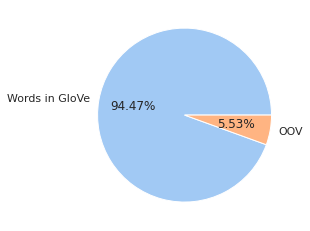

In [ ]:
# Define data for pie chart
oov_percentage = float(len(train_oov_terms) / len(train_word_listing)) * 100
print('The training set has a percentage of OOV words equal to {:.2f}%'.format(oov_percentage))
percentages = [100-oov_percentage, oov_percentage]
labels = ['Words in GloVe', 'OOV',]

# Define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:2]

# Create pie chart
plt.pie(percentages, labels = labels, colors = colors, autopct='%.2f%%')
plt.show()

## Building Embedding Matrix

The next step is to build an embedded matrix. The primary consideration in this process is how to handle OOV words. We have used the approach of assigning a weighted average of neighbour words for OOV words. The implementation is as follows:

* Given a word w
* If w is in the embedding model vocabulary -> assign embedding model vector

	Else
    * If random strategy -> assign random vector (also check the vector value range to generate the vector correctly)
    * If neighbour strategy -> get the co-occurrence vector of word w (window size equal to 1). For each word in the retrieved vector with count >= 1, get the corresponding embedding vector (if it is not an OOV term). At this point, compute a (weighted) average of the retrieved embedding vectors and assign it to word w. If word w has no neighbours, assign a random vector just like point 4.

We tested both strategies, the random strategy in a separated notebook, and the neighbour strategy as our final implementation.

In [ ]:
# Function definition
import random
import scipy.sparse
def build_embedding_matrix(embedding_model, embedding_dimension,
                           word_to_idx, oov_terms, oov_terms_heuristic = 'none',df=None, old_embedding_matrix = []):
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param oov_terms: list of OOV terms (list)

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    """
    #A matrix to find the maximum and minimum value to rescale the random vector
    embedding_matrix_value_generator = np.zeros((len(word_to_idx)+1, embedding_model.vector_size), dtype=float)
    exception = ['--oov--']
    for w, i in word_to_idx.items():
      if w not in oov_terms and w not in exception:
        embedding_matrix_value_generator[i] = embedding_model[w]
    min_value, max_value = embedding_matrix_value_generator.min(), embedding_matrix_value_generator.max()

    embedding_matrix = np.zeros((len(word_to_idx)+1, embedding_model.vector_size), dtype=float)

    if oov_terms_heuristic == 'none':
      for w, i in word_to_idx.items():
        if w not in oov_terms and w not in exception:
          embedding_matrix[i] = embedding_model[w]


#Calculation of OOV words random allotment of vectors

    if oov_terms_heuristic == 'random':
      for w, i in word_to_idx.items():
        if w not in oov_terms and w not in exception:
          embedding_matrix[i] = embedding_model[w]
        else:
          embedding_matrix[i] = random_heuristic(w, embedding_model, min_value, max_value) # Select here an heuristic for the embedding assignment, three are provided.

#Calculation of OOV words with respect to the average of all other words in its co-occurance row
###VERY VERY SLOW

    if oov_terms_heuristic == 'neighbour':
      co_occurrence_matrix = co_occurrence_count(df, idx_to_word, word_to_idx, window_size=1)
      for w, i in word_to_idx.items():
        if w not in oov_terms and w not in exception:
          embedding_matrix[i] = embedding_model[w]
      for w1, i1 in word_to_idx.items():
        if w1 in oov_terms and w1 in exception:
          for w2, i2 in word_to_idx.items():
            if w1 != w2:
              embedding_matrix[i1] += embedding_matrix[i2] * (co_occurrence_matrix[i1,i2] / scipy.sparse.csr_matrix.sum(co_occurrence_matrix[word_to_idx[w1]]))

    return embedding_matrix

def zero_heuristic(word, embedding_model):
  return np.zeros((embedding_model.vector_size,), dtype=float)

def random_heuristic(word, embedding_model, min_value, max_value):
  random_vector =  np.random.uniform(low=min_value, high=max_value, size=(embedding_model.vector_size,))
  return random_vector


#word_tokenizer, tag_tokenizer, train_word_listing, train_word_to_idx, train_idx_to_word = words_tokenizer(train_sentences, train_tags)

word_tokenizer, tag_tokenizer, train_word_listing, train_word_to_idx, train_idx_to_word = words_tokenizer(list(train_sentences)+list(validation_sentences), train_tags)
train_oov_terms = check_OOV_terms(embedding_model, train_word_listing)
# Testing
train_embedding_matrix = build_embedding_matrix(embedding_model, embedding_dimension, train_word_to_idx, train_oov_terms, oov_terms_heuristic = 'random', df=train_sentences)

print("Embedding matrix shape: {}".format(train_embedding_matrix.shape))

Embedding matrix shape: (9903, 300)


## Encoding of Input and Output Data

We will encode all the datasets using the training vocabulary we have created. In this way all the words would be replaced by their corresponding indices which would help in extracting the specific vectors from the embedding matrix.

Whereas, we shall create a tokenizer to encode tags, which would later be used for one hot encoding to be suitable for using in our neural networks.

In [ ]:
#word_tokenizer, tag_tokenizer, word_listing, word_to_idx, idx_to_word = words_tokenizer(train_sentences, train_tags)
oov_terms = check_OOV_terms(embedding_model, train_word_listing)
embedding_matrix = build_embedding_matrix(embedding_model, embedding_dimension, word_to_idx, oov_terms, oov_terms_heuristic = 'random', df=train_sentences)

# use the tokeniser to encode input sequence
X_train_encoded = np.array(word_tokenizer.texts_to_sequences(train_sentences))
X_validation_encoded = np.array(word_tokenizer.texts_to_sequences(validation_sentences))
X_test_encoded = np.array(word_tokenizer.texts_to_sequences(test_sentences))

# encode Y

y_train_encoded =  np.array(tag_tokenizer.texts_to_sequences(train_tags))
y_validation_encoded =  np.array(tag_tokenizer.texts_to_sequences(validation_tags))
y_test_encoded =  np.array(tag_tokenizer.texts_to_sequences(test_tags))


# look at first encoded data point
print("** Raw data point **", "\n", "-"*70, "\n")
print('X: ', train_sentences[0], '\n')
print('Y: ', train_tags[0], '\n')
print("** Encoded data point **", "\n", "-"*70, "\n")
print('X: ', X_train_encoded[0], '\n')
print('Y: ', y_train_encoded[0], '\n')

** Raw data point ** 
 ---------------------------------------------------------------------- 

X:  ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'] 

Y:  ['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.'] 

** Encoded data point ** 
 ---------------------------------------------------------------------- 

X:  [4830, 3273, 2, 2549, 76, 321, 2, 41, 2079, 3, 134, 23, 7, 1734, 344, 475, 2550, 4] 

Y:  [3, 3, 8, 12, 6, 7, 8, 21, 13, 5, 2, 4, 5, 7, 2, 3, 12, 9] 



<ipython-input-19-810d98d23be6>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_encoded = np.array(word_tokenizer.texts_to_sequences(train_sentences))
<ipython-input-19-810d98d23be6>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_validation_encoded = np.array(word_tokenizer.texts_to_sequences(validation_sentences))
<ipython-input-19-810d98d23be6>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you me

### Pad sequences

The sentences in the corpus are not of the same length. Before we feed the input into the RNN model, we need to fix the sentences' length. It is impossible to dynamically allocate the memory required to process each sentence in the corpus as they are of different lengths.

Therefore the next step after encoding the data is to define the sequence length. For that, we need to either pad short sentences or truncate long sentences to a fixed length.

It is essential to point out that this fixed length is a hyperparameter of our strategy, which defines our model's expressiveness and the time to train the model.

Our dataset's largest sentence has 250 tokens; we choose 100 token-length that we would expect to be a reasonable commitment between expressiveness and training time.

In [ ]:
from keras_preprocessing.sequence import pad_sequences
# Pad each sequence to MAX_SEQ_LENGTH using KERAS’ pad_sequences() function.
# Sentences longer than MAX_SEQ_LENGTH are truncated.
# Sentences shorter than MAX_SEQ_LENGTH are padded with zeroes.
# Truncation and padding can either be ‘pre’ or ‘post’.
# For padding we are using ‘pre’ padding type, that is, add zeroes on the left side.
# For truncation, we are using ‘post’, that is, truncate a sentence from right side.
# sequences greater than 100 in length will be truncated
#MAX_SEQ_LENGTH =  len(max(sentences, key=len))
print('Max Sequence Length: ',len(max(train_sentences,key=len)))
MAX_SEQ_LENGTH = 100
print('Defined Sequence Length: ',MAX_SEQ_LENGTH)
X_train_padded = pad_sequences(X_train_encoded, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
X_validation_padded = pad_sequences(X_validation_encoded, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
X_test_padded = pad_sequences(X_test_encoded, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
y_train_padded = pad_sequences(y_train_encoded, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
y_validation_padded = pad_sequences(y_validation_encoded, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
y_test_padded = pad_sequences(y_test_encoded, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')

# print the first sequence
print(X_train_padded[0], "\n"*3)
print(y_train_padded[0])

Max Sequence Length:  250
Defined Sequence Length:  100
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0 4830 3273
    2 2549   76  321    2   41 2079    3  134   23    7 1734  344  475
 2550    4] 



[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  3  3  8 12  6  7  8 21 13  5  2  4  5  7
  2  3 12  9]


In [ ]:
print(X_train_padded.shape)
print(X_validation_padded.shape)
print(X_test_padded.shape)
print(y_train_padded.shape)
print(y_validation_padded.shape)
print(y_test_padded.shape)

(1938, 100)
(1256, 100)
(636, 100)
(1938, 100)
(1256, 100)
(636, 100)


## Visulization of Tags

We visualized the tags tokenizer to get insights of the data, particularly observing the punctuation symbols since we will discard them while analyzing are data sets.  

Then, we create a vector of all tokens without those punctuation symbols.

In [ ]:
tag_to_idx = tag_tokenizer.word_index
print(tag_to_idx)
#Let's list the labels of non punctuations symbols
punctuations = [',','.',':','?','!',';','$','``',"''",'#', '--oov--', '-'] # We consider special characters as punctuation ($,', `,#)
labels=[]
[labels.append(s) for k,s in tag_to_idx.items() if k not in punctuations ]
print(labels)
print('Labels size: {}'.format(len(labels)))

{'--oov--': 1, 'nn': 2, 'nnp': 3, 'in': 4, 'dt': 5, 'nns': 6, 'jj': 7, ',': 8, '.': 9, 'vbd': 10, 'rb': 11, 'cd': 12, 'vb': 13, 'cc': 14, 'vbz': 15, 'vbn': 16, 'to': 17, 'prp': 18, 'vbg': 19, 'vbp': 20, 'md': 21, 'prp$': 22, '``': 23, 'pos': 24, "''": 25, '$': 26, ':': 27, 'wdt': 28, 'jjr': 29, 'wp': 30, 'rp': 31, 'nnps': 32, 'jjs': 33, 'wrb': 34, 'rbr': 35, '-rrb-': 36, '-lrb-': 37, 'ex': 38, 'rbs': 39, 'ls': 40, 'pdt': 41, 'wp$': 42, 'fw': 43, 'uh': 44, 'sym': 45, '#': 46}
[2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
Labels size: 38


## Splitting the data in Train, Validation and Test datasets


Before using RNN, we must make sure that the we provide the expected data dimensions. In general, an RNN expects the following shape:

    Shape of X: (#samples, #timesteps, #features)

Since, depending on the type of architecture, there can be variations in the RNN's shape. The problem that we are working on has a many-to-many architecture, the input and the output both include number of timesteps which is nothing but the sequence length. But notice that the tensor X doesn’t have the third dimension, that is, number of features. That’s because we’re going to use word embeddings before feeding in the data to an RNN, and hence there is no need to explicitly mention the third dimension. That’s because when you use the Embedding() layer in Keras, the training data will automatically be converted to (#samples, #timesteps, #features) where #features will be the embedding dimension (and note that the Embedding layer is always the very first layer of an RNN). While using the embedding layer we only need to reshape the data to (#samples, #timesteps) which was done previously. However, note that you’ll need to shape it to (#samples, #timesteps, #features) in case you don’t use the Embedding() layer in Keras.

As explained before, we have used the one-hot encodding for the output padded y-vectors and we split the X-padded input dataset as per the length of sentences in each dataset found in the beginning of the code.  

In [ ]:
from keras.utils.np_utils import to_categorical
# use Keras’ to_categorical function to one-hot encode Y
def one_hot_encoder(vector):
  one_hot_encoded_vector = []
  for i in range(0,len(vector)):
    encoded_tag = to_categorical(vector[i],47)
    one_hot_encoded_vector.append(encoded_tag)
  return np.array(one_hot_encoded_vector)


#Splitting the dataset into train, test and validation
print('No. Training sentences: {}'.format(number_training_sentences))
print('No. Validation sentences: {}'.format(number_validation_sentences))
print('No. Test sentences: {}'.format(number_test_sentences))


X_train = X_train_padded
X_validation = X_validation_padded
X_test = X_test_padded
y_train = one_hot_encoder(y_train_padded)
y_validation = one_hot_encoder(y_validation_padded)
y_test = one_hot_encoder(y_test_padded)

print(y_train.shape)

No. Training sentences: 1938
No. Validation sentences: 1256
No. Test sentences: 636
(1938, 100, 47)


In [ ]:
# Plot the loss and the accuracy scores on the training and validation s

def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(model_history.history[m])
    plt.plot(model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

## RNN Models

Now, let’s build the RNN model. We’re going to use word embeddings to represent the words. And, during the training of the model, you can also train the word embeddings along with the network weights. These are often called the embedding weights. While training, the embedding weights will be treated as normal weights of the network which are updated in each iteration.

We will define the elements that would remain consistent for our models and analysis. Before defining the baseline model as indicated by the tutor we will implement vanilla rnn for better understanding of the working of the RNNs.


In the next few sections before the base line model, we will try the following three RNN models:

* RNN with arbitrarily initialized, untrainable embeddings: In this model, we will initialize the embedding weights arbitrarily. Further, we’ll freeze the embeddings, that is, we won’t allow the network to train them.

* RNN with arbitrarily initialized, trainable embeddings: In this model, we’ll allow the network to train the embeddings.

* RNN with trainable Glove embeddings: In this experiment, we’ll use Glove word embeddings and also allow the network to train them further.


In [ ]:
# MAX_SEQ_LENGTH = 100,defining the maximum size of each sentence

from keras import Sequential
from keras.layers import Embedding,SimpleRNN,TimeDistributed,Dense,LSTM,GRU,Bidirectional
EMBEDDING_SIZE  = embedding_matrix.shape[1] # # Dimension of the embeding matrix GLove 300
VOCABULARY_SIZE = len(word_to_idx) + 1
NUM_CLASSES = len(tag_tokenizer.word_index) + 1 #47
EPOCHS=30
print(VOCABULARY_SIZE)

9903


## Uninitialized fixed embeddings
Let’s start with the first experiment: a vanilla RNN with arbitrarily initialized, untrainable embedding. For this RNN we won’t use the pre-trained word embeddings. We’ll use randomly initialized embeddings. Moreover, we won’t update the embeddings weights.

In [ ]:
# create architecture
rnn_model = Sequential()
# create embedding layer — usually the first layer in text problems
# vocabulary size — number of unique words in data
rnn_model.add(Embedding(input_dim = VOCABULARY_SIZE,
# length of vector with which each word is represented
 output_dim = EMBEDDING_SIZE,
# length of input sequence
 input_length = MAX_SEQ_LENGTH,
# False — don’t update the embeddings
 trainable = False
))
# add an RNN layer which contains 64 RNN cells
# True — return whole sequence; False — return single output of the end of the sequence
rnn_model.add(SimpleRNN(64,
 return_sequences=True
))
# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))
#compile model
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])
# check summary of the model
rnn_model.summary()

#fit model
rnn_training = rnn_model.fit(X_train, y_train, batch_size=128, epochs=EPOCHS, validation_data=(X_validation, y_validation))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          2970900   
                                                                 
 simple_rnn (SimpleRNN)      (None, 100, 64)           23360     
                                                                 
 time_distributed (TimeDistr  (None, 100, 47)          3055      
 ibuted)                                                         
                                                                 
Total params: 2,997,315
Trainable params: 26,415
Non-trainable params: 2,970,900
_________________________________________________________________
Epoch 1/30
16/16 [==============================] - 8s 397ms/step - loss: 3.0735 - acc: 0.6180 - val_loss: 1.8141 - val_acc: 0.7517
Epoch 2/30
16/16 [==============================] - 7s 457ms/step - loss: 1.4400 - acc: 0.7565 - val_loss: 

## Uninitialized trainable embeddings
Next, try the second model — RNN with arbitrarily initialized, trainable embeddings. Here, we’ll allow the embeddings to get trained with the network. All I am doing is changing the parameter trainable to true i.e trainable = True. Rest all remains the same as above. On checking the model summary we can see that all the parameters have become trainable. i.e trainable params are equal to total params.

In [ ]:
# create architecture
rnn_model = Sequential()
# create embedding layer — usually the first layer in text problems
# vocabulary size — number of unique words in data
rnn_model.add(Embedding(input_dim = VOCABULARY_SIZE,
# length of vector with which each word is represented
 output_dim = EMBEDDING_SIZE,
# length of input sequence
 input_length = MAX_SEQ_LENGTH,
# False — don’t update the embeddings
 trainable = True
))
# add an RNN layer which contains 64 RNN cells
# True — return whole sequence; False — return single output of the end of the sequence
rnn_model.add(SimpleRNN(64,
 return_sequences=True
))
# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))
#compile model
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])
# check summary of the model
rnn_model.summary()

#fit model
rnn_training = rnn_model.fit(X_train, y_train, batch_size=128, epochs=EPOCHS, validation_data=(X_validation, y_validation))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          2970900   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100, 64)           23360     
                                                                 
 time_distributed_1 (TimeDis  (None, 100, 47)          3055      
 tributed)                                                       
                                                                 
Total params: 2,997,315
Trainable params: 2,997,315
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
16/16 [==============================] - 4s 206ms/step - loss: 2.7114 - acc: 0.5656 - val_loss: 1.5610 - val_acc: 0.7544
Epoch 2/30
16/16 [==============================] - 3s 189ms/step - loss: 1.1997 - acc: 0.7606 - val_loss: 1.0

## Using pre-trained embedding weights
Let’s now try the third experiment — RNN with trainable Gloves embeddings. Recall that we had loaded the Glove embeddings in a matrix called 'embedding_weights'. Using Glove embeddings is just as easy as including this matrix in the model architecture.
The network architecture is the same as above but instead of starting with an arbitrary embedding matrix, we’ll use pre-trained embedding weights (weights = [embedding_weights])

The results decreased marginally in this case. That’s because the model was already performing very well. You’ll see much more improvements by using pre-trained embeddings in cases where you don’t have such a good model performance. Pre-trained embeddings provide a real boost in many applications.

In [ ]:
# create architecture
rnn_model = Sequential()
# create embedding layer — usually the first layer in text problems
# vocabulary size — number of unique words in data
rnn_model.add(Embedding(input_dim = VOCABULARY_SIZE,
# length of vector with which each word is represented
 output_dim = EMBEDDING_SIZE,
# length of input sequence
 input_length = MAX_SEQ_LENGTH,
#Initializing weight
weights = [embedding_matrix],
# False — don’t update the embeddings
 trainable = True
))
# add an RNN layer which contains 64 RNN cells
# True — return whole sequence; False — return single output of the end of the sequence
rnn_model.add(SimpleRNN(64,
 return_sequences=True
))
# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))
#compile model
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])
# check summary of the model
rnn_model.summary()

#fit model
rnn_training = rnn_model.fit(X_train, y_train, batch_size=128, epochs=EPOCHS, validation_data=(X_validation, y_validation))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 300)          2970900   
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 100, 64)           23360     
                                                                 
 time_distributed_2 (TimeDis  (None, 100, 47)          3055      
 tributed)                                                       
                                                                 
Total params: 2,997,315
Trainable params: 2,997,315
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
16/16 [==============================] - 6s 269ms/step - loss: 1.9122 - acc: 0.6640 - val_loss: 0.9935 - val_acc: 0.7722
Epoch 2/30
16/16 [==============================] - 3s 192ms/step - loss: 0.8910 - acc: 0.7843 - val_loss: 0.8

## Baseline Model (Bidirectional LSTM)- Model-1

To solve the vanishing gradients problem, many attempts have been made to tweak the vanilla RNNs such that the gradients don’t die when sequences get long. The most popular and successful of these attempts has been the long, short-term memory network, or the LSTM. LSTMs have proven to be so effective that they have almost replaced vanilla RNNs.

Thus, one of the fundamental differences between an RNN and an LSTM is that an LSTM has an explicit memory unit which stores information relevant for learning some task. In the standard RNN, the only way the network remembers past information is through updating the hidden states over time, but it does not have an explicit memory to store information.

On the other hand, in LSTMs, the memory units retain pieces of information even when the sequences get really long.

### Bidirectional LSTM

For example, when you want to assign a sentiment score to a piece of text (say a customer review), the network can see the entire review text before assigning them a score. On the other hand, in a task such as predicting the next word given previous few typed words, the network does not have access to the words in the future time steps while predicting the next word.

These two types of tasks are called offline and online sequence processing respectively.

Now, there is a neat trick you can use with offline tasks — since the network has access to the entire sequence before making predictions, why not use this task to make the network ‘look at the future elements in the sequence’ while training, hoping that this will make the network learn better?
This is the idea exploited by what is called bidirectional RNNs.
By using bidirectional RNNs, it is almost certain that you’ll get better results. However, bidirectional RNNs take almost double the time to train since the number of parameters of the network increase. Therefore, you have a tradeoff between training time and performance. The decision to use a bidirectional RNN depends on the computing resources that you have and the performance you are aiming for.

Finally, let’s build our baseline model — a bidirectional LSTM model

In [ ]:
# definition of callback for early stopping

callback = EarlyStopping(
    monitor="val_acc",
    min_delta=0.0001,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False
)

In [ ]:
#Bidirectional LSTM
#baseline model
# create architecture
baseline_model = Sequential()
baseline_model.add(Embedding(input_dim = VOCABULARY_SIZE,
 output_dim = EMBEDDING_SIZE,
 input_length = MAX_SEQ_LENGTH,
 weights = [embedding_matrix],
 trainable = False
))
baseline_model.add(Bidirectional(LSTM(64, return_sequences=True)))
baseline_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))
#compile model
baseline_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
# check summary of model
baseline_model.summary()


baseline_training = baseline_model.fit(X_train, y_train, batch_size=128, epochs=EPOCHS, validation_data=(X_validation, y_validation), callbacks=callback)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          2970900   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         186880    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 100, 47)          6063      
 ibuted)                                                         
                                                                 
Total params: 3,163,843
Trainable params: 192,943
Non-trainable params: 2,970,900
_________________________________________________________________
Epoch 1/30
16/16 [==============================] - 23s 858ms/step - loss: 1.5121 - acc: 0.7120 - val_loss: 0.9109 - val_acc: 0.7693
Epoch 2/30
16/16 [=====================

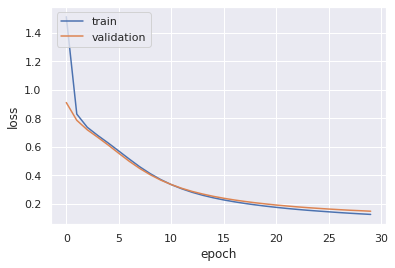

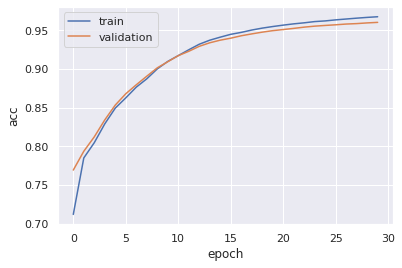

In [ ]:
plot_history(baseline_training,['loss','val_loss'])
plot_history(baseline_training,['acc','val_acc'])

## Modified Model 2 (GRU Model)

Keeping in mind the computational expenses and the problem of overfitting, researchers have tried to come up with alternate structures of the LSTM cell.
The most popular one of these alternatives is the gated recurrent unit (GRU). GRU being a simpler model than LSTM, it's always easier to train. LSTMs and GRUs have almost completely replaced the standard RNNs in practice because they’re more effective and faster to train than vanilla RNNs (despite the larger number of parameters).

Let’s now build a GRU model.

In [ ]:
#modified model 1
#GRU
# create architecture
modified_model_2 = Sequential()
# vocabulary size — number of unique words in data
# length of vector with which each word is represented
modified_model_2.add(Embedding(input_dim = VOCABULARY_SIZE,
 output_dim = EMBEDDING_SIZE,
# length of input sequence
input_length = MAX_SEQ_LENGTH,
# word embedding matrix
weights = [embedding_matrix],
# True — update embeddings_weight matrix
trainable = False
))
# add an GRU layer which contains 64 GRU cells
# True — return whole sequence; False — return single output of the end of the sequence
modified_model_2.add(GRU(64, return_sequences=True))
modified_model_2.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))
#compile model
modified_model_2.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])
# check summary of the model
modified_model_2.summary()

#fit model
modified_2_training = modified_model_2.fit(X_train, y_train, batch_size=128, epochs=EPOCHS, validation_data=(X_validation, y_validation), callbacks=callback)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          2970900   
                                                                 
 gru (GRU)                   (None, 100, 64)           70272     
                                                                 
 time_distributed_1 (TimeDis  (None, 100, 47)          3055      
 tributed)                                                       
                                                                 
Total params: 3,044,227
Trainable params: 73,327
Non-trainable params: 2,970,900
_________________________________________________________________
Epoch 1/30
16/16 [==============================] - 7s 323ms/step - loss: 1.6032 - acc: 0.7171 - val_loss: 0.9298 - val_acc: 0.7661
Epoch 2/30
16/16 [==============================] - 5s 295ms/step - loss: 0.8666 - acc: 0.7759 - val_loss

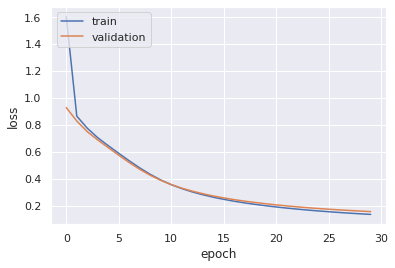

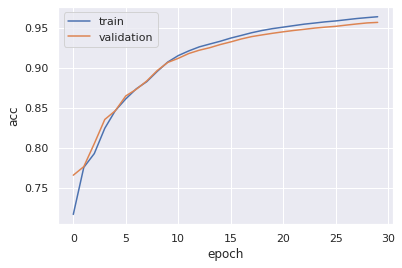

In [ ]:
plot_history(modified_2_training,['loss','val_loss'])
plot_history(modified_2_training,['acc','val_acc'])

## Modified Model 3 (Baseline Model with addtional LSTM Layer)

As specified by the tutor, additional layer of LSTM is used on top of baseline model


In [ ]:
#modified model 2
#Bidirectional LSTM
# create architecture
modified_model_3 = Sequential()
modified_model_3 .add(Embedding(input_dim = VOCABULARY_SIZE,
 output_dim = EMBEDDING_SIZE,
 input_length = MAX_SEQ_LENGTH,
 weights = [embedding_matrix],
 trainable = False
))
modified_model_3 .add(Bidirectional(LSTM(64, return_sequences=True)))
modified_model_3 .add(LSTM(64, return_sequences=True))
modified_model_3 .add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))
#compile model
modified_model_3 .compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
# check summary of model
modified_model_3 .summary()

#fit model
modified_3_training = modified_model_3.fit(X_train, y_train, batch_size=128, epochs=EPOCHS, validation_data=(X_validation, y_validation), callbacks=callback)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 300)          2970900   
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 128)         186880    
 nal)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 100, 64)           49408     
                                                                 
 time_distributed_2 (TimeDis  (None, 100, 47)          3055      
 tributed)                                                       
                                                                 
Total params: 3,210,243
Trainable params: 239,343
Non-trainable params: 2,970,900
_________________________________________________________________
Epoch 1/30
16/16 [====================

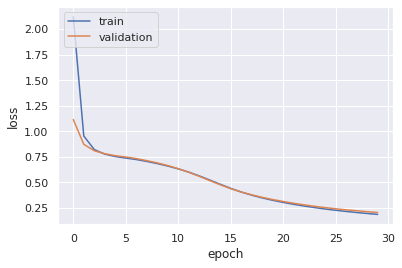

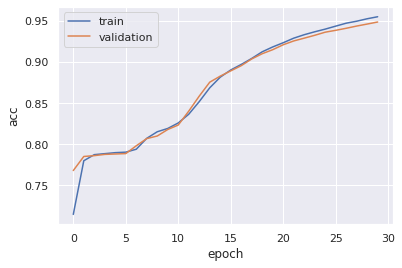

In [ ]:
plot_history(modified_3_training,['loss','val_loss'])
plot_history(modified_3_training,['acc','val_acc'])

## Our GRU model is promissing, let's check it adding a LSTM extra-layer

### Modified Model 4
An lstm layer on top of GRU layer

In [ ]:
#model 1 (modified)
#GRU
# create architecture
modified_model_4 = Sequential()
# vocabulary size — number of unique words in data
# length of vector with which each word is represented
modified_model_4.add(Embedding(input_dim = VOCABULARY_SIZE,
 output_dim = EMBEDDING_SIZE,
# length of input sequence
input_length = MAX_SEQ_LENGTH,
# word embedding matrix
weights = [embedding_matrix],
# True — update embeddings_weight matrix
trainable = False
))
# add an GRU layer which contains 64 GRU cells
# True — return whole sequence; False — return single output of the end of the sequence
modified_model_4.add(GRU(64, return_sequences=True))
modified_model_4.add(LSTM(64, return_sequences=True))

modified_model_4.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))
#compile model
modified_model_4.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])
# check summary of the model
modified_model_4.summary()


#fit model
modified_4_training = modified_model_4.fit(X_train, y_train, batch_size=128, epochs=EPOCHS, validation_data=(X_validation, y_validation), callbacks=callback)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 300)          2970900   
                                                                 
 gru_1 (GRU)                 (None, 100, 64)           70272     
                                                                 
 lstm_3 (LSTM)               (None, 100, 64)           33024     
                                                                 
 time_distributed_3 (TimeDis  (None, 100, 47)          3055      
 tributed)                                                       
                                                                 
Total params: 3,077,251
Trainable params: 106,351
Non-trainable params: 2,970,900
_________________________________________________________________
Epoch 1/30
16/16 [==============================] - 15s 553ms/step - loss: 2.0464 - acc: 0.7206 - val_lo

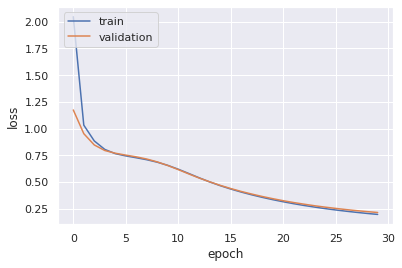

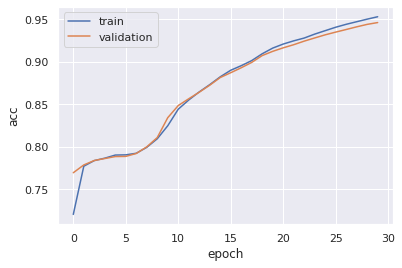

In [ ]:
plot_history(modified_4_training,['loss','val_loss'])
plot_history(modified_4_training,['acc','val_acc'])

### Modified Model 5
An Bi-Directional Lstm layer on top of GRU layer

In [ ]:
#model 1 (modified 2)
#GRU
# create architecture
modified_model_5 = Sequential()
# vocabulary size — number of unique words in data
# length of vector with which each word is represented
modified_model_5.add(Embedding(input_dim = VOCABULARY_SIZE,
 output_dim = EMBEDDING_SIZE,
# length of input sequence
input_length = MAX_SEQ_LENGTH,
# word embedding matrix
weights = [embedding_matrix],
# True — update embeddings_weight matrix
trainable = False
))
# add an GRU layer which contains 64 GRU cells
# True — return whole sequence; False — return single output of the end of the sequence
modified_model_5.add(GRU(64, return_sequences=True))
modified_model_5.add(Bidirectional(LSTM(64, return_sequences=True)))
#modified_model_4.add(Bidirectional(LSTM(64, return_sequences=True)))

modified_model_5.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))
#compile model
modified_model_5.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])
# check summary of the model
modified_model_5.summary()

#fit model
modified_5_training = modified_model_5.fit(X_train, y_train, batch_size=128, epochs=EPOCHS, validation_data=(X_validation, y_validation), callbacks=callback)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 300)          2970900   
                                                                 
 gru_2 (GRU)                 (None, 100, 64)           70272     
                                                                 
 bidirectional_2 (Bidirectio  (None, 100, 128)         66048     
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 100, 47)          6063      
 tributed)                                                       
                                                                 
Total params: 3,113,283
Trainable params: 142,383
Non-trainable params: 2,970,900
_________________________________________________________________
Epoch 1/30
16/16 [====================

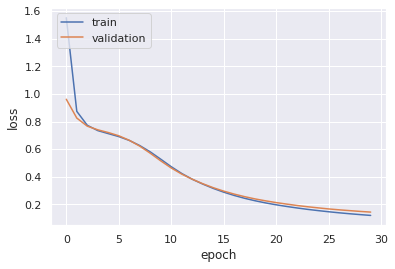

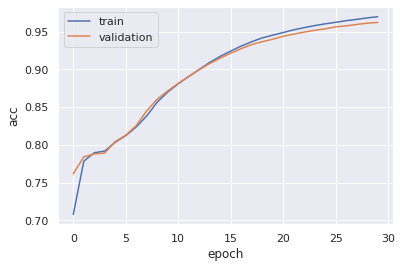

In [ ]:
plot_history(modified_5_training,['loss','val_loss'])
plot_history(modified_5_training,['acc','val_acc'])

## Evaluation of the Implemented Models

We will use various parameters to evaluate our models. Initially we will find the F1 score of all our baseline and modified models. First we find the performance of our models according to the validation sets.

In [ ]:
from sklearn.metrics import f1_score
# The truth of the validation set
y_val_classes = y_validation_padded
y_val_classes = y_val_classes.flatten()
result_dict ={}

#Model Baseline-Model-1
loss, accuracy = baseline_model.evaluate(X_validation, y_validation, verbose = 1)
yhat_classes = baseline_model.predict(X_validation, verbose=1)
yhat_classes = np.argmax(yhat_classes,axis=-1).flatten()
f1 = f1_score(yhat_classes , y_val_classes, average='macro')
result_dict['base'] = [accuracy,f1]

#Model 2
loss, accuracy = modified_model_2.evaluate(X_validation, y_validation, verbose = 1)
yhat_classes = modified_model_2.predict(X_validation, verbose=1)
yhat_classes = np.argmax(yhat_classes,axis=-1).flatten()
f1 = f1_score(y_val_classes , yhat_classes, average='macro')
result_dict['model2'] = [accuracy,f1]


#Model 3
loss, accuracy = modified_model_3.evaluate(X_validation, y_validation, verbose = 1)
yhat_classes = modified_model_3.predict(X_validation, verbose=1)
yhat_classes = np.argmax(yhat_classes,axis=-1).flatten()
f1 = f1_score(y_val_classes , yhat_classes, average='macro')
result_dict['model3'] = [accuracy,f1]


#Model 4
loss, accuracy = modified_model_4.evaluate(X_validation, y_validation, verbose = 1)
yhat_classes = modified_model_4.predict(X_validation, verbose=1)
yhat_classes = np.argmax(yhat_classes,axis=-1).flatten()
f1 = f1_score(y_val_classes , yhat_classes, average='macro')
result_dict['model4'] = [accuracy,f1]

#Model 5
loss, accuracy = modified_model_5.evaluate(X_validation, y_validation, verbose = 1)
yhat_classes = modified_model_5.predict(X_validation, verbose=1)
yhat_classes = np.argmax(yhat_classes,axis=-1).flatten()
f1 = f1_score(y_val_classes , yhat_classes, average='macro')
result_dict['model5'] = [accuracy,f1]

40/40 [==============================] - 4s 64ms/step


Model: 	Accuracy: 	F1-score:
base 	0.96 		0.61
model2 	0.96 		0.61
model3 	0.95 		0.47
model4 	0.95 		0.47
model5 	0.96 		0.59


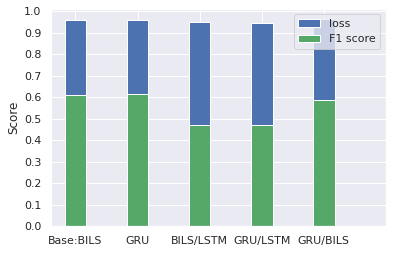

In [ ]:
# Let's print and plot the results of our models
# these are the values without the early stopping
loss=[]
f1_score=[]
print('Model: \tAccuracy: \tF1-score:')
[print('{} \t{:.2f} \t\t{:.2f}'.format(key,value[0],value[1]))
 for key,value in result_dict.items()]
[loss.append(value[0])
 for key,value in result_dict.items()]
[f1_score.append(value[1])
 for key,value in result_dict.items()]
# print(loss)
# print(f1_score)
p1 = plt.bar(list(result_dict.keys()),loss,color='b',width=0.35)
p2 = plt.bar(list(result_dict.keys()),f1_score,color='g',width=0.35)
plt.xticks([0,1,2,3,4,5],['Base:BILS','GRU','BILS/LSTM','GRU/LSTM','GRU/BILS'])

plt.ylabel('Score')
plt.yticks(np.arange(0,1.1,0.1))
plt.legend(('loss','F1 score'))
plt.show()

## Manual inspection

Let's inspect our result on our two best models with the test set.
Our resultings are quite convincing since for these particular sentences we were able to predict the same POS tagging as our test classification. The two best models are Baseline and GRU as they have the highest f1 score on the validation set. (**Baseline - 0.60** and **GRU - 0.58**)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix


y_test_classes = y_test_padded
# predict probabilities for test set
yhat_probs = baseline_model.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = baseline_model.predict(X_test, verbose=0)
yhat_classes = np.argmax(yhat_classes,axis=-1).flatten()
def show_tags (v):
    result=[]
    [result.append(tag_tokenizer.index_word[x].upper()) for x in v if x != 0 ]
    return(result)
def show_tokens (v):
    result=[]
    [result.append(word_tokenizer.index_word[x]) for x in v if x != 0 ]
    return(result)


print('Let''s take a look to our results: ')
print('Sentence[0]:  ')
print(show_tokens(X_test[0]))
print('Prediction[0]:  ')
print(show_tags(yhat_classes))
print('Test[0]:  ')
print(show_tags(y_test_classes[0]))

Lets take a look to our results: 
Sentence[0]:  
['--oov--', '--oov--', 'inc.', ',', 'san', 'antonio', ',', 'texas', ',', 'said', 'it', 'bought', '2.7', 'million', 'shares', ',', 'or', 'about', '18', '%', ',', 'of', 'its', 'common', 'stock', 'from', 'an', '--oov--', 'shareholder', 'for', '$', '--oov--', 'a', 'share', ',', 'or', '$', '9.9', 'million', '.']
Prediction[0]:  
['NNP', 'NNP', 'NNP', ',', 'NNP', 'NNP', ',', 'NNP', ',', 'VBD', 'PRP', 'VBD', 'CD', 'CD', 'NNS', ',', 'CC', 'IN', 'CD', 'NN', ',', 'IN', 'PRP$', 'JJ', 'NN', 'IN', 'DT', 'JJ', 'NN', 'IN', '$', 'CD', 'DT', 'NN', ',', 'CC', '$', 'CD', 'CD', '.', 'DT', 'NNP', 'VBZ', 'NNP', 'NNP', 'NNP', 'NNP', 'POS', 'NN', 'TO', 'CD', 'NN', 'IN', 'CD', 'NN', 'CC', 'MD', 'VB', 'VB', 'NNP', 'NN', 'IN', 'VBG', 'DT', 'NN', 'IN', 'DT', 'NN', 'NN', '.', 'NNP', 'NNP', 'RB', 'VBZ', 'VBG', 'TO', 'NNP', 'NNP', 'NNP', 'IN', 'NN', 'IN', 'NNP', 'NNP', ',', 'DT', 'NNP', 'NNP', '.', 'DT', 'NN', 'NN', 'IN', 'CD', 'NN', 'DT', 'NN', 'NN', 'IN', 'PRP', 'MD

In [ ]:
#Using the Y_padded as we are trying to find the metrics according to the class predicted by the model
y_test_classes = y_test_classes.flatten()

### Closer look on the Baseline model

Since our Baseline model provided the best results on our validation set, we use it to compute values on our test set.

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_classes , yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_classes , yhat_classes, average='micro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_classes , yhat_classes, average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_classes , yhat_classes, average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.958255
Precision: 0.958255
Recall: 0.958255
F1 score: 0.673519


### Deeper look on our classification
We take a look at the F1-score and support of each feature. We observe that some features have a small or no support at all. This is also capture on the F1-score plot.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1

              precision    recall  f1-score   support

           2       0.75      0.81      0.78      2383
           3       0.62      0.87      0.72      1504
           4       0.93      0.94      0.94      1630
           5       0.97      0.98      0.98      1335
           6       0.80      0.70      0.75       941
           7       0.62      0.55      0.58       918
          10       0.84      0.76      0.80       634
          11       0.64      0.64      0.64       381
          12       0.89      0.86      0.87       858
          13       0.85      0.82      0.83       403
          14       0.98      0.94      0.96       366
          15       0.94      0.85      0.89       280
          16       0.69      0.52      0.59       366
          17       1.00      1.00      1.00       386
          18       0.96      0.96      0.96       192
          19       0.72      0.33      0.45       221
          20       0.83      0.64      0.73       134
          21       0.96    

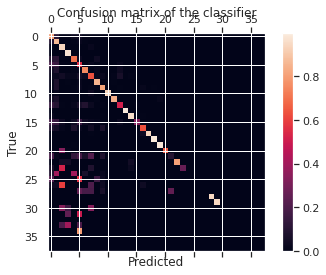

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
import itertools
# task as multiclass classification
# labels has been ammended to not include the punctuations
report = classification_report(y_test_classes .astype('int'), yhat_classes.astype('int'),
                               labels=labels)
print(report)
confusion_matrix = confusion_matrix(y_test_classes .astype('int'), yhat_classes.astype('int'),
                                    labels=labels)
fig = plt.figure()
ax = fig.add_subplot(111)
np.seterr(divide='ignore', invalid='ignore')
# Let's normalize the confusion matrix for plotting
confusion_matrix = confusion_matrix.astype('float') / (confusion_matrix.sum(axis=1)[:, np.newaxis] +1)
cax = ax.matshow(confusion_matrix)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
####################################################################

### Error analysis - Checking the least frequent Tags
We will check the performance of our Baseline model on the test set after removing the punctuations and the least frequent tags.

The least frequent tags are the ones that contributes to low or zero f1-score. We considered a tag F1-score below 0.3 as a low score on our analysis.

In [ ]:
report = classification_report(y_test_classes .astype('int'), yhat_classes.astype('int'),
                               labels=labels, zero_division=0,output_dict=True)
# Just show the least frequent Tags i.e. F1-score < .5
print('ID:Tag\t- Support\tF1-score')

for k,v in report.items():
    if k.isnumeric() and v['f1-score'] < 0.3:
        print('{}:{}\t- {}\t\t{:.2f}'.format(k,tag_tokenizer.index_word[int(k)].upper(),
                               v['support'],
                               v['f1-score']))

ID:Tag	- Support	F1-score
29:JJR	- 59		0.17
32:NNPS	- 44		0.00
33:JJS	- 31		0.00
34:WRB	- 24		0.00
35:RBR	- 15		0.00
38:EX	- 5		0.00
39:RBS	- 3		0.00
40:LS	- 0		0.00
41:PDT	- 4		0.00
42:WP$	- 4		0.00
43:FW	- 0		0.00
44:UH	- 0		0.00
45:SYM	- 0		0.00


In [ ]:
# Let's exclude those 0 support items
tag_to_idx = tag_tokenizer.word_index
# punctuations = [',','.',':','?','!',';','$','``',"''",'#', '--oov--','LS','FW','UH','SYM'] # We consider special characters as punctuation ($,', `,#)

punctuations = [',','.',':','?','!',';','$','``',"''",'#', '--oov--','ls','fw','uh','sym'] # We consider special characters as punctuation ($,', `,#)
#'JJR','RP','NNPS','JJS','WRB','RBR','EX','RBS','PDT','WP'
labels=[]
[labels.append(s) for k,s in tag_to_idx.items() if k not in punctuations ]
# task as multiclass classification
# labels has been ammended to not include the punctuations
report = classification_report(y_test_classes.astype('int'), yhat_classes.astype('int'),
                               labels=labels, zero_division=0)
print(report)

              precision    recall  f1-score   support

           2       0.75      0.81      0.78      2383
           3       0.62      0.87      0.72      1504
           4       0.93      0.94      0.94      1630
           5       0.97      0.98      0.98      1335
           6       0.80      0.70      0.75       941
           7       0.62      0.55      0.58       918
          10       0.84      0.76      0.80       634
          11       0.64      0.64      0.64       381
          12       0.89      0.86      0.87       858
          13       0.85      0.82      0.83       403
          14       0.98      0.94      0.96       366
          15       0.94      0.85      0.89       280
          16       0.69      0.52      0.59       366
          17       1.00      1.00      1.00       386
          18       0.96      0.96      0.96       192
          19       0.72      0.33      0.45       221
          20       0.83      0.64      0.73       134
          21       0.96    

####Here we observed that the f1 macro for Baseline was 0.54 but after removal of the punctuations and the least frequent tags, it increased to 0.61.

##Model 2 (GRU Model)

###GRU is the second best model and now using GRU, we will perform all the analysis we did on the Baseline.

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix


y_test_classes = y_test_padded
# predict probabilities for test set
yhat_probs = modified_model_2.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = modified_model_2.predict(X_test, verbose=0)
yhat_classes = np.argmax(yhat_classes,axis=-1).flatten()
def show_tags (v):
    result=[]
    [result.append(tag_tokenizer.index_word[x].upper()) for x in v if x != 0 ]
    return(result)
def show_tokens (v):
    result=[]
    [result.append(word_tokenizer.index_word[x]) for x in v if x != 0 ]
    return(result)


print('Let''s take a look to our results: ')
print('Sentence[0]:  ')
print(show_tokens(X_test[0]))
print('Prediction[0]:  ')
print(show_tags(yhat_classes))
print('Test[0]:  ')
print(show_tags(y_test_classes[0]))

Lets take a look to our results: 
Sentence[0]:  
['--oov--', '--oov--', 'inc.', ',', 'san', 'antonio', ',', 'texas', ',', 'said', 'it', 'bought', '2.7', 'million', 'shares', ',', 'or', 'about', '18', '%', ',', 'of', 'its', 'common', 'stock', 'from', 'an', '--oov--', 'shareholder', 'for', '$', '--oov--', 'a', 'share', ',', 'or', '$', '9.9', 'million', '.']
Prediction[0]:  
['NNP', 'NNP', 'NNP', ',', 'NNP', 'NNP', ',', 'NNP', ',', 'VBD', 'PRP', 'VBD', 'CD', 'CD', 'NNS', ',', 'CC', 'IN', 'CD', 'NN', ',', 'IN', 'PRP$', 'JJ', 'NN', 'IN', 'DT', 'JJ', 'NN', 'IN', '$', 'CD', 'DT', 'NN', ',', 'CC', '$', 'CD', 'CD', '.', 'DT', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'POS', 'NN', 'TO', 'CD', 'NN', 'IN', 'JJ', 'NN', 'CC', 'MD', 'VB', 'VB', 'NNP', 'NNP', 'IN', 'VBG', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', '.', 'NNP', 'NNP', 'RB', 'VBZ', 'VBG', 'TO', 'NN', 'NNP', 'NNP', 'IN', 'NNP', 'IN', 'JJ', 'NNP', ',', 'DT', 'JJ', 'NN', '.', 'DT', 'NN', 'NN', 'IN', 'CD', 'NN', 'DT', 'JJ', 'NN', 'IN', 'PRP', 'MD', 'VB',

In [ ]:
#Using the Y_padded as we are trying to find the metrics according to the class predicted by the model
y_test_classes = y_test_classes.flatten()

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_classes , yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_classes , yhat_classes, average='micro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_classes , yhat_classes, average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_classes , yhat_classes, average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.953789
Precision: 0.953789
Recall: 0.953789
F1 score: 0.669951


### Deeper look on our classification
We take a look at the F1-score and support of each feature. We observe that some features have a small or no support at all. This is also capture on the F1-score plot.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           2       0.69      0.81      0.75      2383
           3       0.74      0.70      0.72      1504
           4       0.92      0.95      0.93      1630
           5       0.95      0.98      0.96      1335
           6       0.77      0.70      0.73       941
           7       0.43      0.53      0.47       918
          10       0.85      0.73      0.78       634
          11       0.64      0.52      0.58       381
          12       0.89      0.82      0.85       858
          13       0.83      0.81      0.82       403
          14       0.99      0.98      0.99       366
          15       0.91      0.82      0.86       280
          16       0.58      0.60      0.59       366
          17       1.00      1.00      1.00       386
          18       0.96      0.96      0.96       192
          19       0.69      0.30      0.42       221
          20       0.88      0.71      0.79       134
          21       0.93    

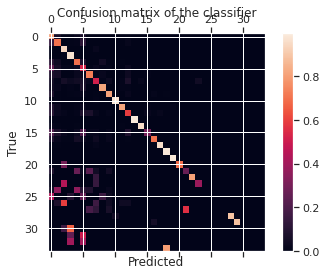

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
import itertools
# task as multiclass classification
# labels has been ammended to not include the punctuations
report = classification_report(y_test_classes .astype('int'), yhat_classes.astype('int'),
                               labels=labels)
print(report)
confusion_matrix = confusion_matrix(y_test_classes .astype('int'), yhat_classes.astype('int'),
                                    labels=labels)
fig = plt.figure()
ax = fig.add_subplot(111)
np.seterr(divide='ignore', invalid='ignore')
# Let's normalize the confusion matrix for plotting
confusion_matrix = confusion_matrix.astype('float') / (confusion_matrix.sum(axis=1)[:, np.newaxis] +1)
cax = ax.matshow(confusion_matrix)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
####################################################################

### Error analysis - Checking the least frequent Tags
We will check the performance of our Baseline model on the test set after removing the punctuations and the least frequent tags.

The least frequent tags are the ones that contributes to low or zero f1-score. We considered a tag F1-score below 0.3 as a low score on our analysis.

In [ ]:
report = classification_report(y_test_classes .astype('int'), yhat_classes.astype('int'),
                               labels=labels, zero_division=0,output_dict=True)
# Just show the least frequent Tags i.e. F1-score < .5
print('ID:Tag\t- Support\tF1-score')

for k,v in report.items():
    if k.isnumeric() and v['f1-score'] < 0.3:
        print('{}:{}\t- {}\t\t{:.2f}'.format(k,tag_tokenizer.index_word[int(k)].upper(),
                               v['support'],
                               v['f1-score']))

ID:Tag	- Support	F1-score
32:NNPS	- 44		0.00
33:JJS	- 31		0.00
34:WRB	- 24		0.00
35:RBR	- 15		0.00
38:EX	- 5		0.00
39:RBS	- 3		0.00
41:PDT	- 4		0.00
42:WP$	- 4		0.00


In [ ]:
# Let's exclude those 0 support items
tag_to_idx = tag_tokenizer.word_index
# punctuations = [',','.',':','?','!',';','$','``',"''",'#', '--oov--','LS','FW','UH','SYM'] # We consider special characters as punctuation ($,', `,#)

punctuations = [',','.',':','?','!',';','$','``',"''",'#', '--oov--','ls','fw','uh','sym'] # We consider special characters as punctuation ($,', `,#)
#'JJR','RP','NNPS','JJS','WRB','RBR','EX','RBS','PDT','WP'
labels=[]
[labels.append(s) for k,s in tag_to_idx.items() if k not in punctuations ]
# task as multiclass classification
# labels has been ammended to not include the punctuations
report = classification_report(y_test_classes.astype('int'), yhat_classes.astype('int'),
                               labels=labels, zero_division=0)
print(report)

              precision    recall  f1-score   support

           2       0.69      0.81      0.75      2383
           3       0.74      0.70      0.72      1504
           4       0.92      0.95      0.93      1630
           5       0.95      0.98      0.96      1335
           6       0.77      0.70      0.73       941
           7       0.43      0.53      0.47       918
          10       0.85      0.73      0.78       634
          11       0.64      0.52      0.58       381
          12       0.89      0.82      0.85       858
          13       0.83      0.81      0.82       403
          14       0.99      0.98      0.99       366
          15       0.91      0.82      0.86       280
          16       0.58      0.60      0.59       366
          17       1.00      1.00      1.00       386
          18       0.96      0.96      0.96       192
          19       0.69      0.30      0.42       221
          20       0.88      0.71      0.79       134
          21       0.93    

####Here we observe that there was no difference in the f1 macro score of the GRU model even after the removal of the punctuations and the least frequent tags. It stayed consistent at 0.60

### Error observations
In the last experiment, not considering Tags that out of our test set, imporved our F1-score for Baseline but not for GRU.

**Baseline**- 0.54 -> 0.61
**GRU** - 0.60 -> 0.60

To conclude, analyzing the POS tagging errors, we verify that our training dataset did not have significant examples for training our RNN appropriately. Tags like NNPS and RBNS have a low score. And, Tags like  PDT, RP, RBR , LS, FW, UH, and SYM have F1-score equal to zero, and most of those tags had no examples in our test dataset.

Choosing a corpora or adding to the corpora sentences with this least frequent Tags would improve the model generation.